In [153]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [154]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples = n_samples, noise = 0.03, random_state= 42)

In [155]:
print(f"First 5 X values:\n{X[:5]}\nFirst 5 y values:\n{y[:5]}")

First 5 X values:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 y values:
[1 1 1 1 0]


In [156]:
import pandas as pd
df = pd.DataFrame({"X1": X[:, 0],
                   "X2": X[:, 1],
                  "label": y
                  })

In [157]:
df.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


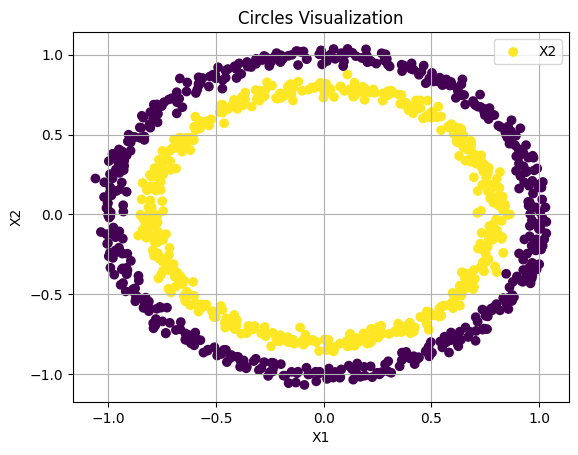

In [158]:
def plot_predictions():
    plt.scatter(data = df, x ="X1", y = "X2", c = 'label')
    plt.title("Circles Visualization")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid()
    plt.legend()

plot_predictions()

In [159]:
X.shape, y.shape

((1000, 2), (1000,))

In [160]:
X_tensor = torch.tensor(X, dtype = torch.float32)
y_tensor = torch.tensor(y, dtype = torch.float32)

X_tensor.shape, y_tensor.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [161]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size= 0.2, random_state= 42)

In [162]:
X_train.shape

torch.Size([800, 2])

In [163]:
# Lets build a model

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [164]:
from torch import nn

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features= 2, out_features= 5) # takes 2 featues and upsacles to 5 features
        self.layer_2 = nn.Linear(in_features= 5, out_features= 1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        # x -> layer_1 -> layer_2
        return self.layer_2(self.layer_1(x))

In [165]:
model_0 = CircleModelV0().to(device)

In [166]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [167]:
model_1 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features= 5, out_features= 1)
).to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [168]:
with torch.inference_mode():
  untrained_preds = model_1(X_test.to(device))
print(untrained_preds[:10].squeeze())
print(y_test[:10])

tensor([-0.4181, -0.4132, -0.5494, -0.3803, -0.7379, -0.7335, -0.5705, -0.6460,
        -0.5413, -0.4150], device='cuda:0')
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [169]:
## setting up a loss function
# loss_fn =nn.BCELoss() - This funciton assumes that the inputs are processed with sigmoid

loss_fn = nn.BCEWithLogitsLoss()
# this is equivalent to but its better in efficency

#loss_fn = nn.Sequential(
#    nn.Sigmoid(),
#    nn.BCELoss()
#)

optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

In [170]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return (correct/len(y_true)) * 100

In [171]:
epoch_count = []
train_loss_val = []
test_loss_val = []
acc = []

epochs = 500

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):

  model_1.train()

  y_preds = model_1.forward(X_train).squeeze()

  loss = loss_fn(y_preds, y_train)

  accuracy = accuracy_fn(y_true = y_train, y_pred = y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    y_train_preds = model_1.forward(X_test)

    loss_test = loss_fn(y_train_preds.squeeze(), y_test)

  if epoch % 10 == 0:
    print(f"Epoch = {epoch} | accuracy = {accuracy} | train_loss = {loss} | test_loss = {loss_test}")
    epoch_count.append(epoch)
    acc.append(accuracy)
    train_loss_val.append(loss)
    test_loss_val.append(loss_test)

Epoch = 0 | accuracy = 0.0 | train_loss = 0.735015869140625 | test_loss = 0.7323002219200134
Epoch = 10 | accuracy = 0.0 | train_loss = 0.7095201015472412 | test_loss = 0.7090392708778381
Epoch = 20 | accuracy = 0.0 | train_loss = 0.6999589204788208 | test_loss = 0.7002094388008118
Epoch = 30 | accuracy = 0.0 | train_loss = 0.6962818503379822 | test_loss = 0.6967850923538208
Epoch = 40 | accuracy = 0.0 | train_loss = 0.6947968602180481 | test_loss = 0.6954145431518555
Epoch = 50 | accuracy = 0.0 | train_loss = 0.6941392421722412 | test_loss = 0.6948398351669312
Epoch = 60 | accuracy = 0.0 | train_loss = 0.6938046813011169 | test_loss = 0.6945851445198059
Epoch = 70 | accuracy = 0.0 | train_loss = 0.6936057209968567 | test_loss = 0.6944671273231506
Epoch = 80 | accuracy = 0.0 | train_loss = 0.69347083568573 | test_loss = 0.6944122314453125
Epoch = 90 | accuracy = 0.0 | train_loss = 0.6933712363243103 | test_loss = 0.6943893432617188
Epoch = 100 | accuracy = 0.0 | train_loss = 0.69329422

In [174]:
def plot_loss():
  plt.scatter(epoch_count, np.array(torch.tensor(train_loss_val).cpu().numpy()), label = 'Train', c="green")
  plt.scatter(epoch_count, np.array(torch.tensor(test_loss_val).cpu().numpy()), label = 'Test', c="orange")
  # plt.scatter(epoch_count, np.array(torch.tensor(acc).cpu().numpy()), label = 'Accuracy', c="lime")
  plt.title("Loss over time")
  plt.xlabel("Epoch")
  plt.ylabel("Loss Value")
  plt.grid()
  plt.legend()

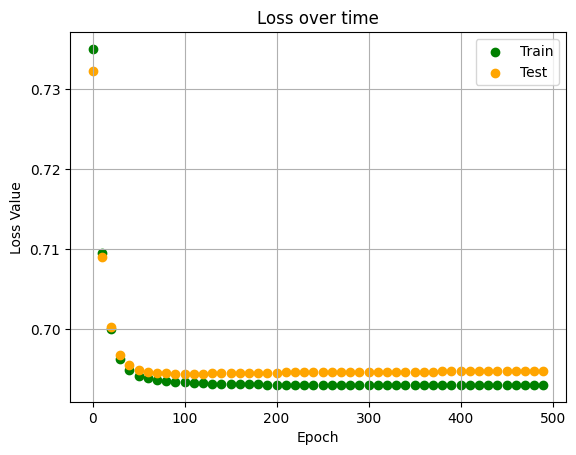

In [175]:
plot_loss()

In [25]:
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  print('helper_funciton already exits! skipping')
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_funciton already exits! skipping


NameError: name 'model_1' is not defined

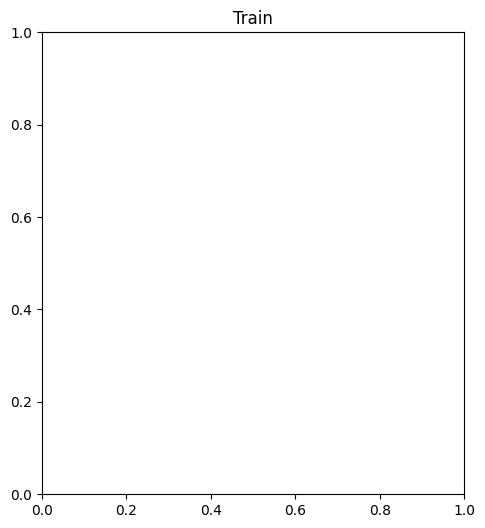

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


In [185]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features= 2, out_features= 10)
    self.layer2 = nn.Linear(in_features= 10, out_features= 10)
    self.layer3 = nn.Linear(in_features= 10, out_features= 1)

  def forward(self, x:torch.tensor) -> torch.tensor:
    return self.layer3(self.layer2(self.layer1(x)))

In [190]:
model_2 = CircleModelV1().to(device)
model_2

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [191]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1)

In [192]:
epochs = 100

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  model_2.train()

  y_pred = model_2.forward(X_train).squeeze()

  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()

  with  torch.inference_mode():
    y_test_preds = model_2.forward(X_test).squeeze()

    loss_test = loss_fn(y_test_preds, y_test)

    if epoch % 10 == 0:
      print(f"Epoch = {epoch} | accuracy = {accuracy} | train_loss = {loss} | test_loss = {loss_test}")


Epoch = 0 | accuracy = 0.0 | train_loss = 0.6935356259346008 | test_loss = 0.6938309073448181
Epoch = 10 | accuracy = 0.0 | train_loss = 0.693293571472168 | test_loss = 0.693630039691925
Epoch = 20 | accuracy = 0.0 | train_loss = 0.6931940317153931 | test_loss = 0.6935595273971558
Epoch = 30 | accuracy = 0.0 | train_loss = 0.6931496262550354 | test_loss = 0.6935396194458008
Epoch = 40 | accuracy = 0.0 | train_loss = 0.6931269764900208 | test_loss = 0.6935394406318665
Epoch = 50 | accuracy = 0.0 | train_loss = 0.6931130886077881 | test_loss = 0.6935468912124634
Epoch = 60 | accuracy = 0.0 | train_loss = 0.693103015422821 | test_loss = 0.6935575604438782
Epoch = 70 | accuracy = 0.0 | train_loss = 0.6930949091911316 | test_loss = 0.6935696005821228
Epoch = 80 | accuracy = 0.0 | train_loss = 0.6930879354476929 | test_loss = 0.69358229637146
Epoch = 90 | accuracy = 0.0 | train_loss = 0.693081796169281 | test_loss = 0.6935952305793762


In [262]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [263]:
model_2_reg = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

In [264]:
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

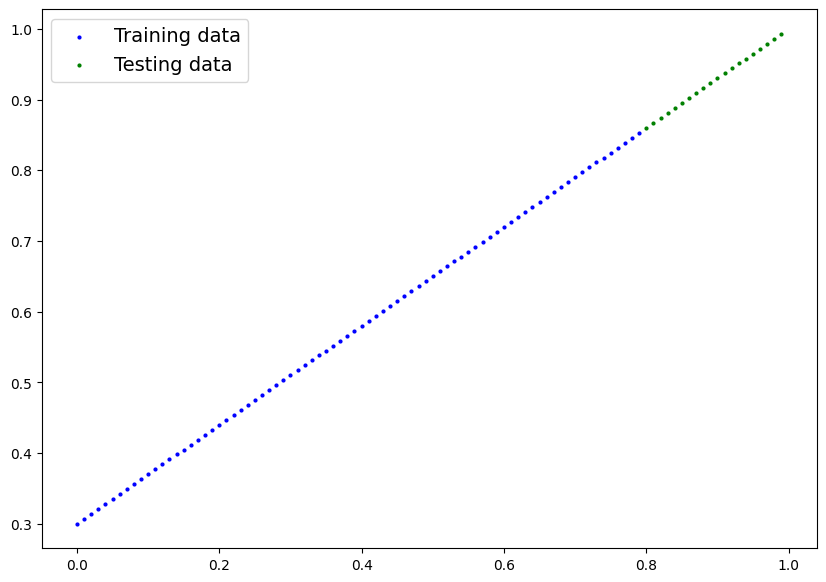

In [265]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);


In [266]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params = model_2_reg.parameters(), lr = 0.01)

X_train_regression.to(device).shape

torch.Size([80, 1])

In [267]:
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

epochs = 100
for epoch in range(epochs):
  model_2_reg.train()

  y_pred = model_2_reg(X_train_regression)

  loss = loss_fn(y_pred, y_train_regression)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2_reg.eval()

  with torch.inference_mode():
    y_test_pred_reg = model_2_reg(X_test_regression)

    loss_test = loss_fn(y_test_pred_reg, y_test_regression)

  if epoch % 10 == 0:
      print(f"Epoch = {epoch} | train_loss = {loss} | test_loss = {loss_test}")


Epoch = 0 | train_loss = 0.46147260069847107 | test_loss = 0.7129915952682495
Epoch = 10 | train_loss = 0.10658067464828491 | test_loss = 0.27311381697654724
Epoch = 20 | train_loss = 0.0992765948176384 | test_loss = 0.23894129693508148
Epoch = 30 | train_loss = 0.09417959302663803 | test_loss = 0.2258588820695877
Epoch = 40 | train_loss = 0.08899953216314316 | test_loss = 0.2137908935546875
Epoch = 50 | train_loss = 0.08372072130441666 | test_loss = 0.2008216679096222
Epoch = 60 | train_loss = 0.07832303643226624 | test_loss = 0.18687580525875092
Epoch = 70 | train_loss = 0.07278549671173096 | test_loss = 0.17187370359897614
Epoch = 80 | train_loss = 0.06709304451942444 | test_loss = 0.15767715871334076
Epoch = 90 | train_loss = 0.06122949346899986 | test_loss = 0.14425818622112274


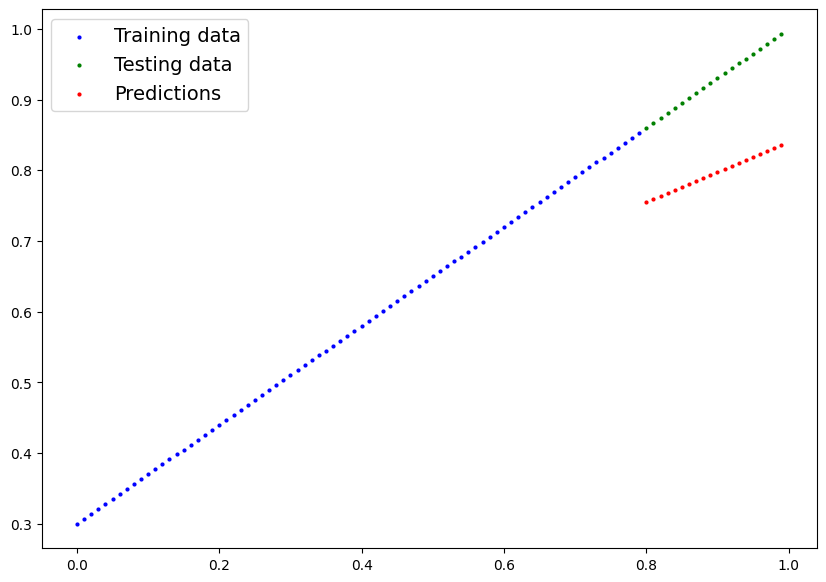

In [269]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2_reg(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());


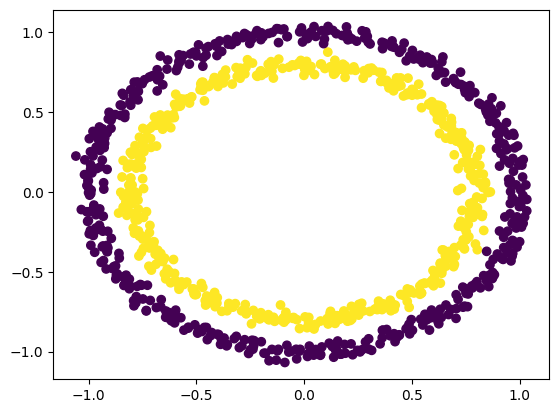

In [10]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

X, y = make_circles(n_samples = 1000, noise = 0.03, random_state = 42)

X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)

plt.scatter(X[:, 0], X[:, 1], c = y)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

In [13]:
model_3 = CircleModelV2()
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [14]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_3.parameters(), lr = 0.1)

In [15]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [22]:
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

epochs = 5000

for epoch in range(epochs):
  model_3.train()

  y_preds = model_3.forward(X_train).squeeze()

  loss = loss_fn(y_preds, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()

  with torch.inference_mode():
    y_test_preds = model_3.forward(X_test).squeeze()

    loss_test = loss_fn(y_test_preds, y_test)

  if epoch % 100 == 0:
    print(f"epoch = {epoch} | train_loss = {loss} | test_los= {loss_test}")

epoch = 0 | train_loss = 0.4322351813316345 | test_los= 0.4368760287761688
epoch = 100 | train_loss = 0.29418063163757324 | test_los= 0.2987937331199646
epoch = 200 | train_loss = 0.18673011660575867 | test_los= 0.18851350247859955
epoch = 300 | train_loss = 0.12846040725708008 | test_los= 0.1304043084383011
epoch = 400 | train_loss = 0.08786115795373917 | test_los= 0.0890725702047348
epoch = 500 | train_loss = 0.06472290307283401 | test_los= 0.06540339440107346
epoch = 600 | train_loss = 0.05061541870236397 | test_los= 0.051017876714468
epoch = 700 | train_loss = 0.04128322750329971 | test_los= 0.04162682592868805
epoch = 800 | train_loss = 0.034711480140686035 | test_los= 0.03511553257703781
epoch = 900 | train_loss = 0.02984968014061451 | test_los= 0.03033892810344696
epoch = 1000 | train_loss = 0.026141049340367317 | test_los= 0.02670345827937126
epoch = 1100 | train_loss = 0.02322450466454029 | test_los= 0.02385461889207363
epoch = 1200 | train_loss = 0.02084789238870144 | test_lo

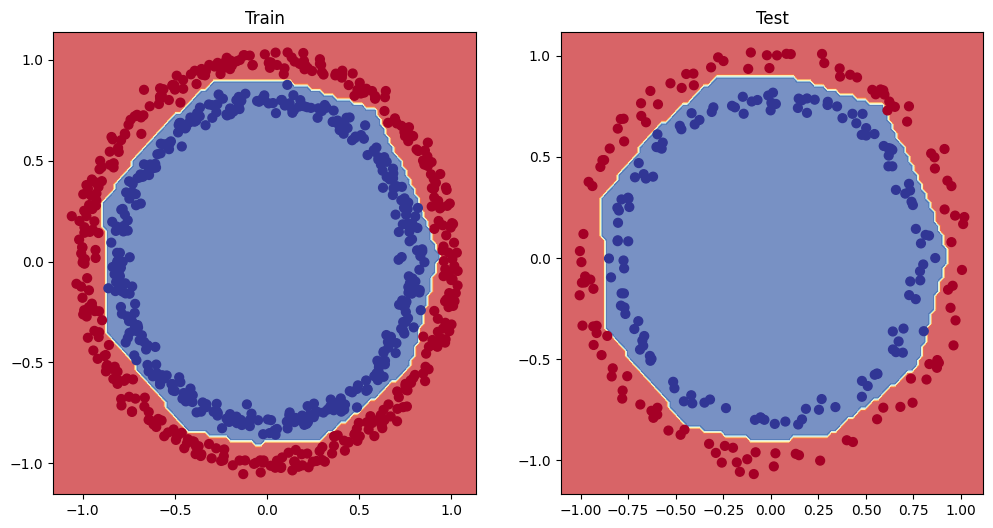

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)


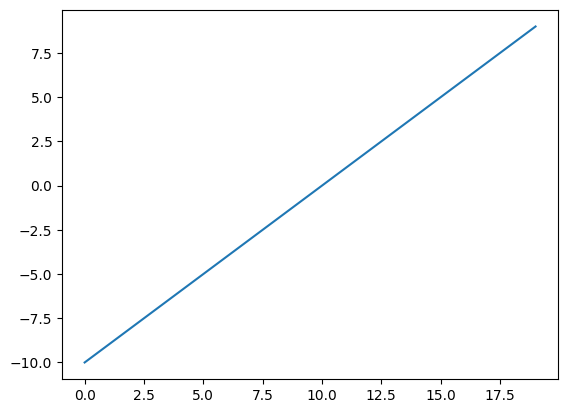

In [33]:
## replicating relu

A = torch.arange(-10., 10., 1.)
plt.plot(A)

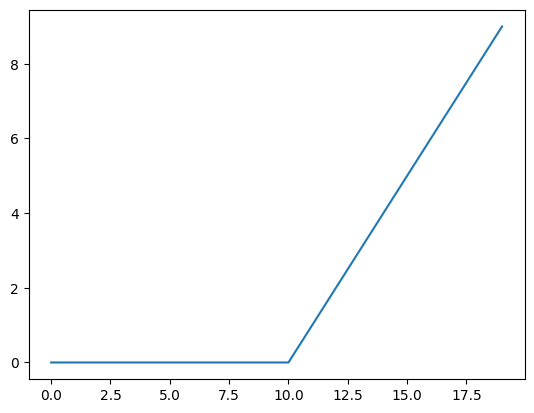

In [34]:
plt.plot(torch.relu(A))

In [35]:
def relu(x):
  return torch.maximum(torch.tensor(0), x)

In [36]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [38]:
def sigmoid(x):
  return 1 / (1 + torch.exp(- x))

In [40]:
torch.sigmoid(A) == sigmoid(A)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

In [58]:
# putting it all togeather
# building multi class function

import torch
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blobs, y_blobs = make_blobs(n_samples= 1000,
                              n_features=NUM_FEATURES,
                              centers=NUM_CLASSES,
                              cluster_std = 1.5,
                              random_state = RANDOM_SEED
                              )

# turn data into tensors

X_blobs, y_blobs = torch.from_numpy(X_blobs).type(torch.float), torch.from_numpy(y_blobs).type(torch.LongTensor)

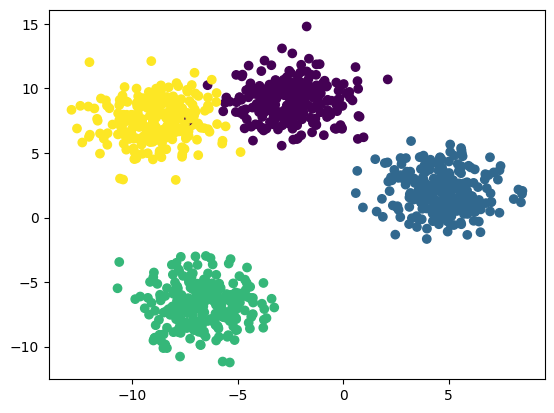

In [59]:
import matplotlib.pyplot as plt
X_blobs.shape, y_blobs.shape
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c = y_blobs)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_blobs, y_blobs)

In [61]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [62]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features= input_features, out_features= hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features= hidden_units, out_features= hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features= hidden_units, out_features= output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


In [63]:
model_4 = BlobModel(2, 4, 8).to(device)

In [64]:
# loss function

loss_fn = nn.CrossEntropyLoss()

# optimizer

optimizer = torch.optim.SGD(params = model_4.parameters(), lr = 0.1)

In [65]:
y_logits = model_4.forward(X_train.to(device))
y_logits.shape

torch.Size([750, 4])

In [66]:
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_pred_probs.shape

torch.Size([750, 4])

In [67]:
y_pred_ = torch.argmax(y_pred_probs, dim = 1)
y_pred_.shape

torch.Size([750])

In [75]:
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
   model_4.train()

   y_logits = model_4.forward(X_train)
  #  print(y_logits.shape)
  #  print(y_train.shape)

  #  # we need to convert our models predicts to probabilities
  #  y_preds_probs = torch.softmax(y_logits, dim = 1)
  # #  print(y_preds_probs.shape)

  #  # we have an array of probs, we need to convert it to actual guess

  #  y_pred = torch.argmax(y_preds_probs, dim = 1)
  #  print(y_pred.shape)

  #  print(y_train.shape)

   loss = loss_fn(y_logits, y_train)

   optimizer.zero_grad()

   loss.backward()

   optimizer.step()

   model_4.eval()

   with torch.inference_mode():
    y_test_pred = model_4.forward(X_test).squeeze()

    loss_test = loss_fn(y_test_pred, y_test)

   if epoch % 100 == 0:
    print(f"Epoch = {epoch} | Train loss = {loss} | Test loss = {loss_test} ")

Epoch = 0 | Train loss = 0.02120867744088173 | Test loss = 0.0150065328925848 
Epoch = 100 | Train loss = 0.021070918068289757 | Test loss = 0.014901423826813698 
Epoch = 200 | Train loss = 0.020935537293553352 | Test loss = 0.014798578806221485 
Epoch = 300 | Train loss = 0.020802447572350502 | Test loss = 0.014697768725454807 
Epoch = 400 | Train loss = 0.020671596750617027 | Test loss = 0.01459882128983736 
Epoch = 500 | Train loss = 0.020542962476611137 | Test loss = 0.014501632191240788 
Epoch = 600 | Train loss = 0.02041655406355858 | Test loss = 0.014406082220375538 
Epoch = 700 | Train loss = 0.02029240131378174 | Test loss = 0.014312119223177433 
Epoch = 800 | Train loss = 0.02017054706811905 | Test loss = 0.014219557866454124 
Epoch = 900 | Train loss = 0.020051077008247375 | Test loss = 0.01412845030426979 


In [69]:
with torch.inference_mode():
  p = model_4.forward(X_test[:5])

print(torch.softmax(p, dim = 1).argmax(dim = 1))
print(y_test[:5])

y_pred

tensor([2, 1, 3, 1, 3])
tensor([2, 1, 3, 1, 3])


tensor([1, 0, 3, 3, 2, 1, 0, 2, 0, 3, 0, 2, 1, 0, 1, 0, 0, 3, 1, 1, 1, 3, 1, 3,
        1, 1, 0, 2, 3, 0, 1, 1, 2, 2, 3, 3, 0, 3, 3, 0, 2, 2, 1, 1, 0, 3, 2, 0,
        1, 0, 0, 0, 2, 1, 1, 2, 3, 1, 2, 2, 0, 3, 1, 1, 1, 0, 2, 1, 1, 3, 3, 3,
        0, 0, 1, 3, 2, 3, 1, 1, 0, 2, 1, 2, 1, 0, 1, 0, 2, 0, 2, 2, 0, 2, 1, 2,
        1, 3, 1, 2, 3, 3, 3, 3, 0, 2, 3, 3, 3, 0, 3, 0, 2, 2, 3, 2, 0, 1, 2, 3,
        3, 2, 2, 2, 3, 1, 1, 2, 1, 1, 2, 2, 3, 2, 0, 0, 0, 0, 0, 0, 1, 3, 1, 2,
        0, 2, 1, 3, 1, 1, 0, 1, 3, 3, 3, 2, 3, 0, 0, 1, 3, 2, 1, 3, 0, 3, 1, 2,
        0, 0, 1, 0, 2, 3, 2, 3, 2, 3, 3, 1, 0, 0, 3, 3, 0, 3, 1, 3, 0, 3, 2, 0,
        3, 0, 3, 3, 1, 2, 0, 0, 1, 1, 0, 3, 0, 1, 1, 3, 0, 3, 3, 1, 2, 1, 2, 3,
        2, 3, 2, 2, 0, 3, 2, 2, 3, 3, 2, 1, 3, 3, 1, 1, 3, 2, 2, 2, 0, 2, 0, 3,
        1, 0, 0, 3, 2, 2, 3, 1, 2, 3, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 2, 3,
        3, 0, 3, 1, 3, 2, 2, 0, 2, 3, 1, 3, 2, 3, 0, 1, 3, 1, 1, 3, 0, 0, 0, 0,
        3, 1, 2, 1, 0, 0, 0, 3, 2, 1, 3,

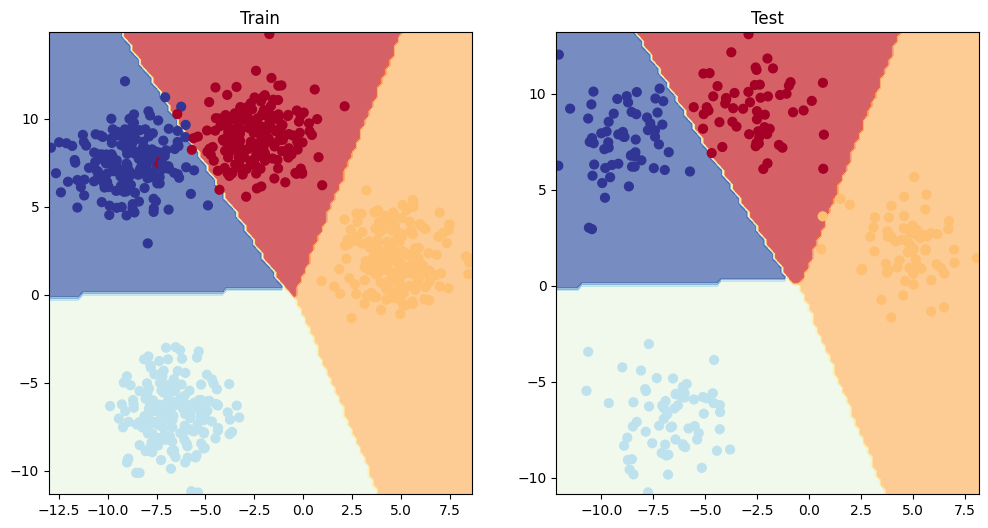

In [70]:
from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)


In [46]:
!pip install torchmetrics

In [76]:
from torchmetrics import Accuracy

y_test_pred = (torch.softmax(y_test_pred, dim =1)).argmax(dim =1)


# torchmetric_accuracy = Accuracy(task = "multiclass", num_classes = 4)
y_test_pred.shape
#

torch.Size([250])

In [77]:
torchmetric_accuracy(y_test, y_test_pred)

tensor(0.9960)